In [1]:
import scib
import latentvelo as ltv
import scanpy as sc
import scvelo as scv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0


# Read process and plot data

In [2]:
adata = sc.read('../synthetic_datasets/knockout_2batches.h5ad')

In [3]:
ltv.utils.anvi_clean_recipe(adata, spliced_key='counts_spliced', unspliced_key='counts_unspliced',
                                 batch_key = 'batch', umap=True, celltype_key='milestone')

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


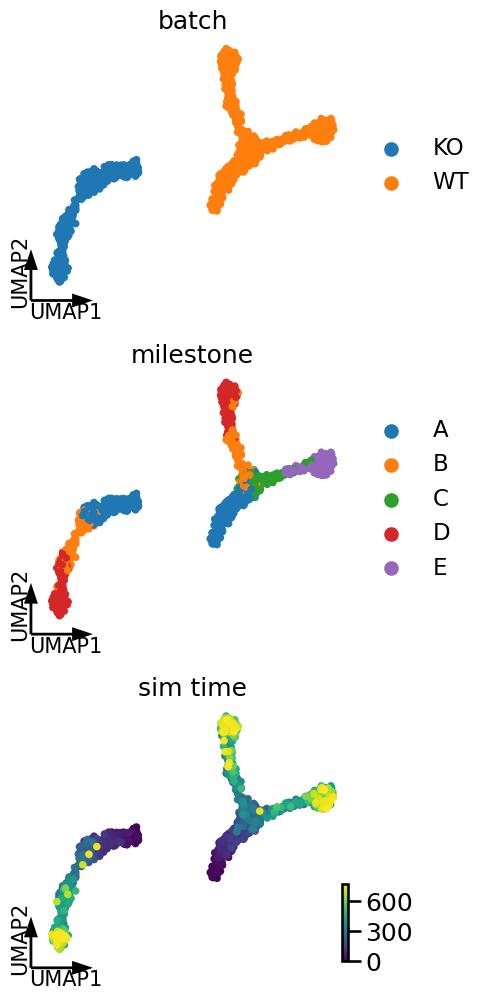

In [4]:
scv.pl.umap(adata, color=['batch', 'milestone', 'sim_time'], frameon='artist', legend_loc='right', ncols=1,
           figsize=(4,4))

# Train VAE model for batch correction

In [5]:
model = ltv.models.AnnotVAE(observed=85, latent_dim=20,
                            zr_dim=1, h_dim=2, batch_correction=True, batches=2, celltypes=5)

In [6]:
epochs, val_ae, val_traj = ltv.train_anvi(model, adata, batch_size = 100,
                                      epochs=100, name='batch_correction_ko_params')

Warning, folder already exists. This may overwrite a previous fit.
39 velocity genes used
epoch 0, full loss 118.894, val loss 98.001, ae MSE 1.217, traj MSE 0.535, reg loss -0.767
epoch 1, full loss 128.318, val loss 63.328, ae MSE 0.435, traj MSE 0.482, reg loss -1.887
epoch 2, full loss 72.653, val loss 54.947, ae MSE 0.395, traj MSE 0.334, reg loss -2.689
epoch 3, full loss 45.493, val loss 44.156, ae MSE 0.387, traj MSE 0.280, reg loss -3.017
epoch 4, full loss 34.151, val loss 33.094, ae MSE 0.296, traj MSE 0.279, reg loss -3.210
epoch 5, full loss 23.581, val loss 23.989, ae MSE 0.276, traj MSE 0.265, reg loss -2.963
epoch 6, full loss 16.127, val loss 17.035, ae MSE 0.283, traj MSE 0.256, reg loss -3.230
epoch 7, full loss 9.601, val loss 10.527, ae MSE 0.267, traj MSE 0.254, reg loss -3.142
epoch 8, full loss 4.873, val loss 4.286, ae MSE 0.255, traj MSE 0.252, reg loss -3.184
epoch 9, full loss -2.328, val loss -1.252, ae MSE 0.252, traj MSE 0.248, reg loss -3.146
epoch 10, f

epoch 83, full loss -154.705, val loss -154.595, ae MSE 0.100, traj MSE 0.101, reg loss -2.618
epoch 84, full loss -155.209, val loss -155.519, ae MSE 0.101, traj MSE 0.101, reg loss -2.558
epoch 85, full loss -155.379, val loss -156.120, ae MSE 0.100, traj MSE 0.101, reg loss -2.612
epoch 86, full loss -156.229, val loss -156.335, ae MSE 0.099, traj MSE 0.100, reg loss -2.605
epoch 87, full loss -156.428, val loss -156.536, ae MSE 0.099, traj MSE 0.101, reg loss -2.617
epoch 88, full loss -157.078, val loss -157.338, ae MSE 0.100, traj MSE 0.100, reg loss -2.533
Epoch 00089: reducing learning rate of group 0 to 1.3348e-03.
epoch 89, full loss -157.692, val loss -157.715, ae MSE 0.099, traj MSE 0.099, reg loss -2.540
epoch 90, full loss -158.065, val loss -158.422, ae MSE 0.099, traj MSE 0.099, reg loss -2.490
epoch 91, full loss -158.515, val loss -159.130, ae MSE 0.099, traj MSE 0.100, reg loss -2.524
epoch 92, full loss -158.663, val loss -159.413, ae MSE 0.099, traj MSE 0.100, reg 

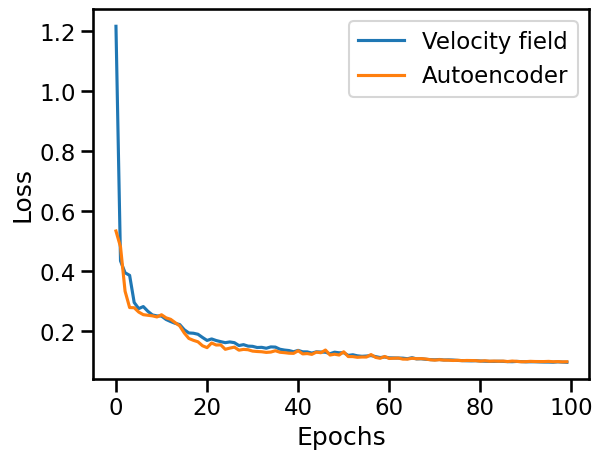

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Get outputs for both models

In [8]:
latent_adata = ltv.output_results(model, adata)

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Plot VAE model on original unintegrated space

computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


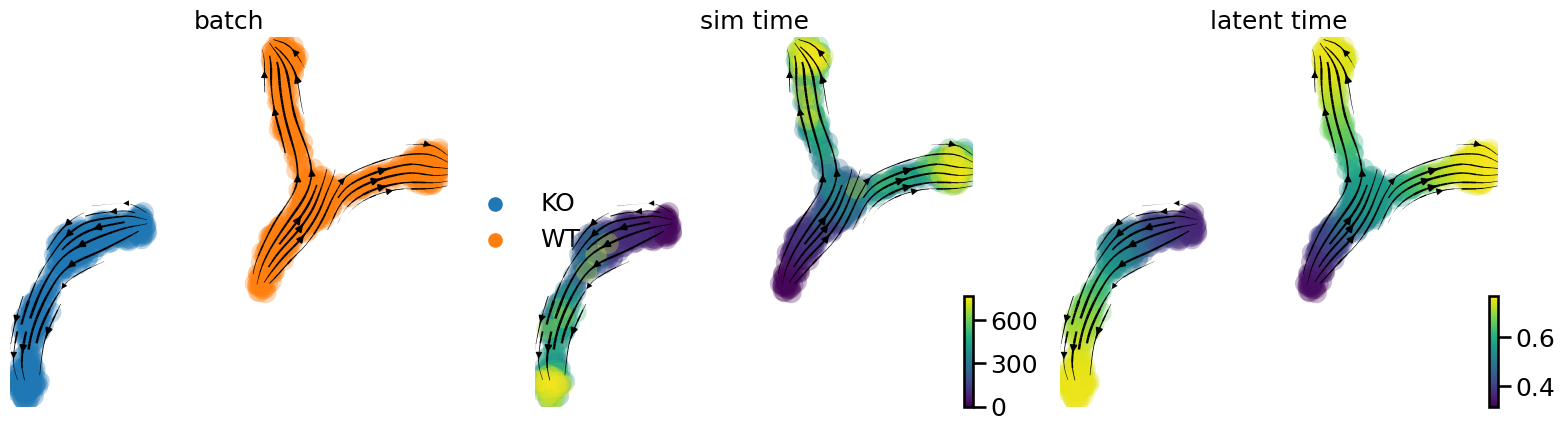

In [10]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['batch', 'sim_time', 'latent_time']
                                , legend_loc='right', legend_fontsize=18)

# Plot VAE model on integrated latent space

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


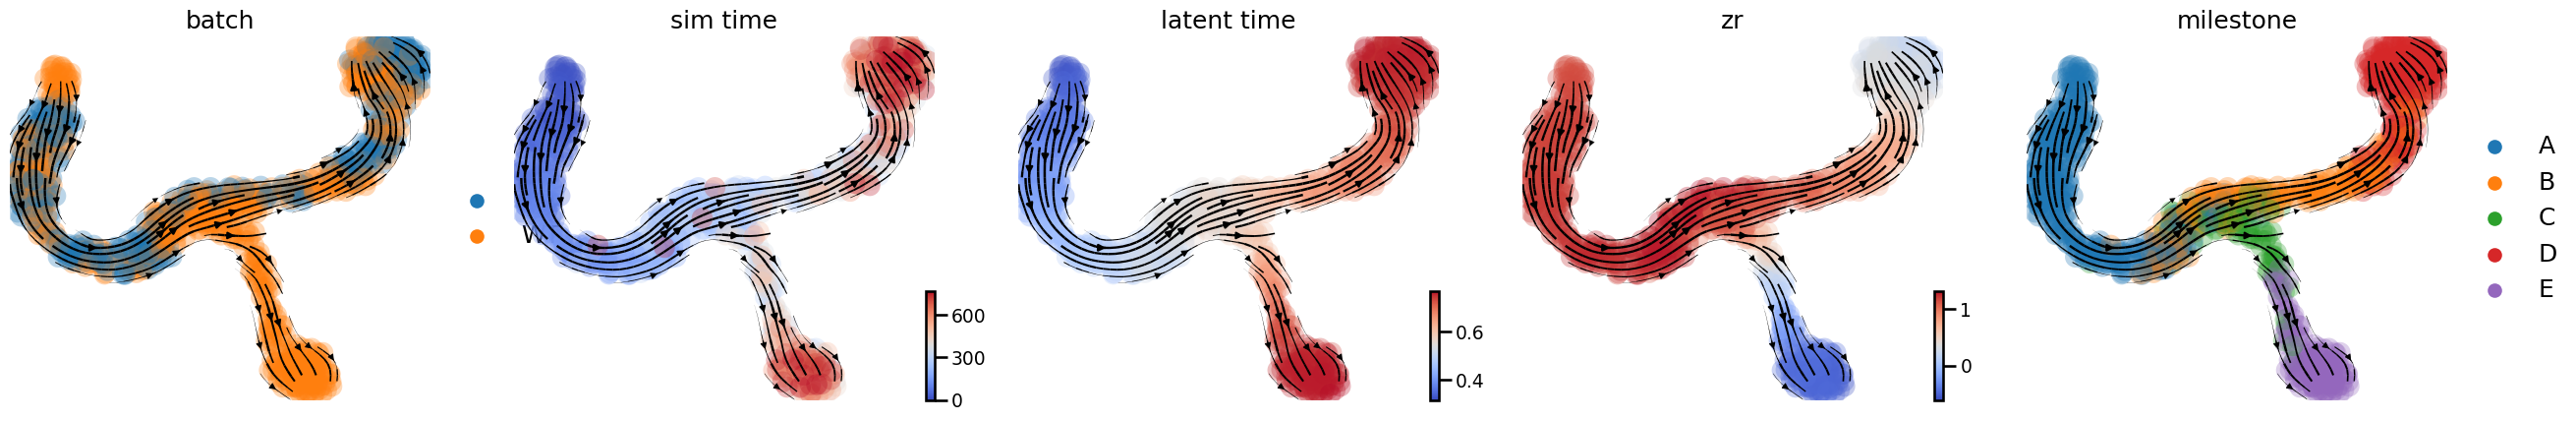

In [11]:
latent_adata.obs['zr'] = latent_adata.obsm['zr'][:,0]
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
scv.tl.umap(latent_adata, min_dist=1)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['batch', 'sim_time', 'latent_time', 'zr', 'milestone'], legend_loc='right',
                                legend_fontsize=18, fontsize=18, color_map='coolwarm')


# Compute gene-expression batch correction metrics

In [12]:
latent_adata.obsm['X_latent'] = latent_adata.X.copy()
ge_metrics = ltv.ev.integration_metrics(latent_adata, label_key='milestone', 
                                         batch_key = 'batch', emb_key='X_latent')

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
C consists of a single batch or is too small. Skip.
E consists of a single batch or is too small. Skip.
Adding diffusion to step 4


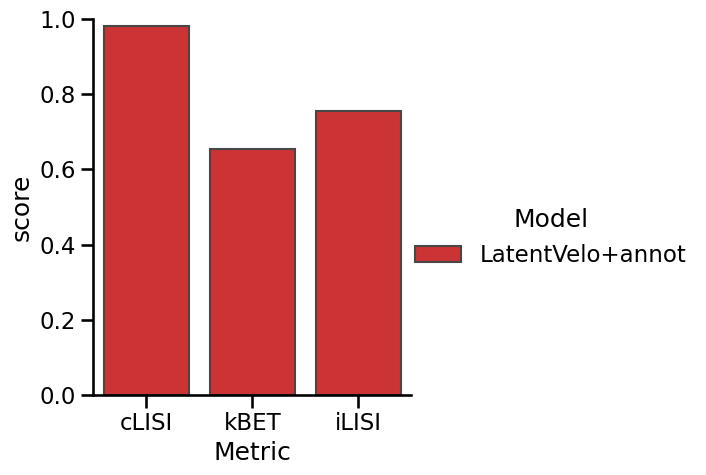

In [13]:
ltv.pl.integration_metrics([ge_metrics],
                           ['LatentVelo+annot'],
                           edgecolor='#474747ff',height=5, aspect=1) # add annot
plt.show()

# Compute velocity batch correction metrics

In [16]:
cluster_edges = [('A', 'B'), ('A', 'C'),
                 ('C', 'E'), ('B', 'D')]

adata.layers['rna_velocity'] = adata.layers['rna_velocity'].todense()
ltv.ev.format_benchmark_adata(adata, latent_adata, estimated_vkey='spliced_velocity')
df = ltv.ev.benchmark_synthetic(adata, basis_list = ['latent'], batch_key='batch', 
                                               cluster_key='milestone', cluster_edges = cluster_edges)

computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1000 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'rna_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_latent', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_20', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_10', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_pca_3', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'rna_velocity_umap', embedded velocity vectors (adata.obsm)


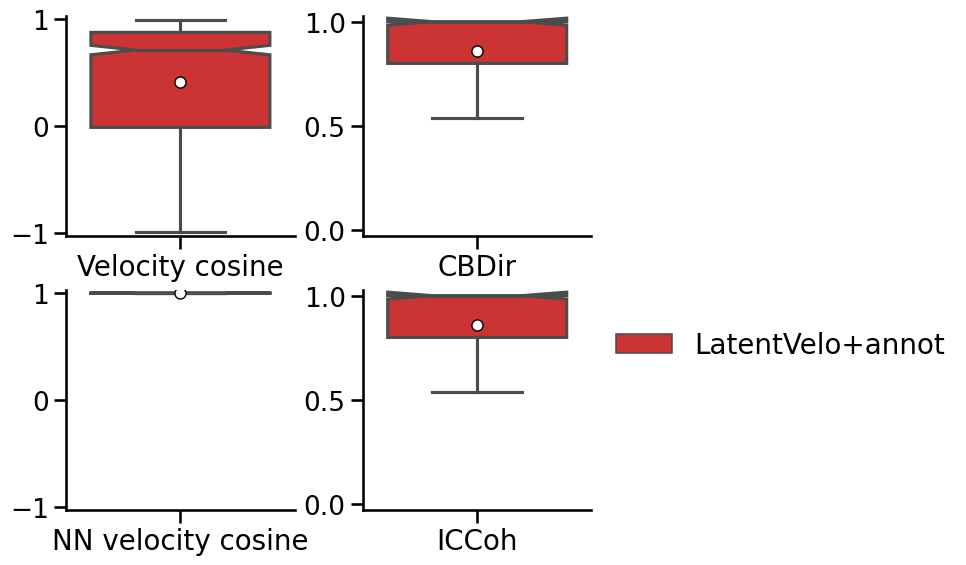

In [17]:
import seaborn as sns
ltv.pl.integration_velocity_metrics([df],
                                     ['LatentVelo+annot'],
                                     ['latent'], figsize=(10,6), 
                                     palette=np.array(sns.color_palette("Set1").as_hex()),
                                    orient='v')
plt.show()